In [1]:
import pandas as pd
import numpy as np
import sed_eval
import dcase_util
import tensorflow as tf
import os
import librosa
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Patch
import datetime
import psds_eval
from psds_eval import PSDSEval, plot_psd_roc, plot_per_class_psd_roc
import warnings
import glob
import models
from scipy import signal
warnings.filterwarnings("ignore", category=FutureWarning) 

tf.keras.backend.clear_session()

In [2]:
# Models to evaluate
models_names = os.listdir('/Users/arvidfalch/Documents/Thesis/Models_FullData')
print(models_names)

['Conv2DLOG_notime_160_20eps', 'Conv2D_RA_lrsched_80', 'Conv1D_mirror_log', '.DS_Store', 'Conv2DLOG_notime_160_40eps', 'Conv2DLOG_notime_160_50eps', 'Conv1dFULL', 'Conv2D_RA_40eps', 'Conv2D_RA_20eps', 'Conv1D_mirror_Fulldata_v2', 'Conv2D_FullData_vREAL_40eps', 'Conv2D_RA_notime_160_70eps_lr_drop', 'Conv2D_FullData_vREAL_20eps', 'Conv2D_RA_3_channels', 'Conv2D_RA_3chan_tanh', 'Conv2DLOG_lr_sched_80', 'Conv1D_pure', 'Conv2D_RA_notime_160_60eps', 'Conv2D_RA_notime_160_40eps', 'Conv1dFULL_20eps']


In [3]:
model_name = 'Conv1D_mirror_Fulldata_v2'
model_folder ='/Users/arvidfalch/Documents/Thesis/Models_FullData'
model_path = model_folder + '/' + model_name
# For ML Node use:
model = tf.keras.models.load_model(model_path)
# For NREC Conv2D_RA use:
#model = models.Conv2D_Model_RA(10,128, [5,2,2], [64,64], [32], 10, 4096, 128, 64)
#model = models.Conv1D_Model(10, 4096, 128, 64, pool_size=64, sr=24000)
#model.load_weights(model_path)


In [4]:
model.summary()

Model: "CRNN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 10, 4096, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv (TimeDistributed)         (None, 10, 4096, 12  8192        ['input[0][0]']                  
                                8)                                                                
                                                                                                  
 conv_batch_norm (TimeDistribut  (None, 10, 4096, 12  512        ['conv[0][0]']                   
 ed)                            8)                                                             

In [5]:
# Path to evaluation data
path_to_eval_set = '/Volumes/Expansion/DESEDpublic_eval(1)/dataset/audio/eval/public/'

# PSDS pandas dataframe creation
label_names = ['Alarm_bell_ringing', 'Blender', 'Cat', 'Dishes', 'Dog', 'Electric_shaver_toothbrush', 'Frying', 'Running_water', 'Speech', 'Vacuum_cleaner']
sr = 24000
win_length = 4096
timesteps = 64 # 64 frames per win_length
dict = 0 # initialize dict
dict = {'filename': [], 'onset': [], 'offset': [], 'label': []}
mean = True # if true, mean of frames in window is used, else max (If set to True set median to False)
median = False # If true, median of frames in window is used, else max or mean
mixed_postprocessing = False
thres = 0.5 # threshold for predictions
time_resolution = 0.15 # time resolution in seconds for predictions (model postprocessing)
filter_notes = 'Hipass filtering'


def reshape_pred(y_pred, n_classes):
    y_pred = np.reshape(y_pred, (-1, n_classes))
    return y_pred

def seconds_to_win_of_frames(seconds, win_length, n_frames, sr=sr):
    frame_size_in_samples = win_length / n_frames
    win_of_frames =  int(seconds * sr / frame_size_in_samples)
    return win_of_frames
    
def return_mean_of_win_of_frames(y_pred, win_of_frames):
    # apply before threshold function
    new_size = int(y_pred.shape[0] / win_of_frames)
    y_pred_mean = np.zeros((new_size, y_pred.shape[1]))
    
    for i in range(0, new_size):
        y_pred_mean[i, :] = np.mean(y_pred[int(i * win_of_frames):int(i * win_of_frames + win_of_frames - 1), ], axis=0)
        
    return y_pred_mean

def return_max_of_win_of_frames(y_pred,win_of_frames):
    # apply before threshold function
    new_size = int(y_pred.shape[0] / win_of_frames)
    y_pred_max = np.zeros((new_size, y_pred.shape[1]))
    
    for i in range(0, new_size):
        y_pred_max[i, :] = np.max(y_pred[int(i * win_of_frames):int(i * win_of_frames + win_of_frames - 1), ], axis=0)
        
    return y_pred_max

def return_median_of_win_of_frames(y_pred,win_of_frames):
    # apply before threshold function
    new_size = int(y_pred.shape[0] / win_of_frames)
    y_pred_max = np.zeros((new_size, y_pred.shape[1]))
    
    for i in range(0, new_size):
        y_pred_max[i, :] = np.median(y_pred[int(i * win_of_frames):int(i * win_of_frames + win_of_frames - 1), ], axis=0)
        
    return y_pred_max

def convert_to_time(index, y_pred, audio, sr=sr, win_length=win_length):
    ms_step = (audio.size / y_pred.shape[0]) / sr
    return index * ms_step

def create_txt_from_predictions(y_pred, filename, audio, label_names, threshold=0.5, dict=dict):

    onset = False
    offset = True
    
    threshold = threshold
    for label in range(len(label_names)): # iterate over all classes
        for idx, frame in enumerate(y_pred): # iterate over all frames
            # The frame is an array of 10 values
            # Look up one class at the time
            if frame[label] >= threshold:
                if onset is True:
                    if idx == y_pred.shape[0]-1:
                        dict['offset'].append(10) 
                        offset = True
                        onset = False

                    else:
                        pass
                
                else:
                    
                    if convert_to_time(idx, y_pred, audio)>10.0:
                        pass
                    else:
                        onset = True
                        offset = False
                        dict['onset'].append(convert_to_time(idx, y_pred, audio)) 
                        dict['label'].append(label_names[label])
                        dict['filename'].append(filename)
                        if idx == y_pred.shape[0]-1:
                            dict['offset'].append(10) 
                            offset = True
                            onset = False
                    
            else:
                if offset is True:
                    pass
                else:
                    onset = False
                    offset = True
                    dict['offset'].append(convert_to_time(idx, y_pred, audio)) 
                
def create_txt_from_predictions_PSDS(y_pred, filename, audio, label_names, threshold=0.5, dict=dict):

    onset = False
    offset = True
    
    threshold = threshold
    for label in range(len(label_names)): # iterate over all classes
        for idx, frame in enumerate(y_pred): # iterate over all frames
            # The frame is an array of 10 values
            # Look up one class at the time
            if frame[label] >= threshold:
                if onset is True:
                    if idx == y_pred.shape[0]-1:
                        dict['offset'].append(10) 
                        offset = True
                        onset = False

                    else:
                        pass
                
                else:
                    
                    if convert_to_time(idx, y_pred, audio)>10.0:
                        pass
                    else:
                        onset = True
                        offset = False
                        dict['onset'].append(convert_to_time(idx, y_pred, audio)) 
                        dict['event_label'].append(label_names[label])
                        dict['filename'].append(filename)
                        if idx == y_pred.shape[0]-1:
                            dict['offset'].append(10) 
                            offset = True
                            onset = False
                    
            else:
                if offset is True:
                    pass
                else:
                    onset = False
                    offset = True
                    dict['offset'].append(convert_to_time(idx, y_pred, audio)) 
                


files = os.listdir(path_to_eval_set)

filenames = [x for x in files if not x.startswith('._')]

def filter(x):
    numtaps = 99
    freqs = [0, 0.042, 1]
    gains = [0, 1, 1]

    b = signal.firwin2(numtaps, freqs, gains)
    s = signal.lfilter(b, 1, x)
    return s

def audio_shaper(audio, sr=sr, win_length=win_length):
    # Filter Audio
    #audio = filter(audio)
    if audio.size < 240000:
        audio = np.pad(audio, (0,240000-audio.size))
    elif audio.size > 240000:
        audio = audio[0:240000]
    else:
        audio = audio
    audio = np.pad(audio, (0,5760))
    audio = np.reshape(audio, (6,10,win_length,1))
    
    return audio



win_of_frames = seconds_to_win_of_frames(time_resolution, win_length, timesteps, sr=sr)

# PSDS dir and num_points

# Creating the save dir for the txt files
try:
    os.mkdir(model_name + 'PSDS_eval/', mode = 0o777)
except OSError:
    pass

eval_save_dir_PSDS = model_name + 'PSDS_eval/'

# Setting a list of detection thresholds
num_operating_points = 50
detection_thresholds = np.round(np.linspace(0.1, 0.99, num_operating_points), decimals=2)

# Creating a dict of dictionaries for each threshold
dict_PSDS = {}
for i in detection_thresholds:
    dict_PSDS.update({i: {'filename': [], 'onset': [], 'offset': [], 'event_label': []}}) 

# Iterating over the files in the eval set
# Predicting and saving the predictions to dictionaries according to threshold

meta_filename = []
meta_dur = []

for file in filenames:
    if file.find('wav')!=-1:
        audio, _ = librosa.load(path_to_eval_set+file, sr=sr)
        audio = audio_shaper(audio)
        meta_filename.append(file)
        meta_dur.append(np.round((audio.size/sr), decimals=1))
        y_pred = model.predict(audio)
        y_pred = reshape_pred(y_pred, 10)
        if mixed_postprocessing is True:
            y_pred = return_max_of_win_of_frames(y_pred, win_of_frames//2)
            y_pred = return_mean_of_win_of_frames(y_pred, 2)
        else:     
            if median is False: 
                if mean is True:        
                    y_pred = return_mean_of_win_of_frames(y_pred, win_of_frames)
                else:
                    y_pred = return_max_of_win_of_frames(y_pred, win_of_frames)
            else:
                y_pred = return_median_of_win_of_frames(y_pred, win_of_frames)
        create_txt_from_predictions(y_pred, file, audio, label_names, threshold=thres, dict=dict)
        for i in detection_thresholds:
        # Appending the predictions to the correct dictionary
            create_txt_from_predictions_PSDS(y_pred, file, audio, label_names, threshold=i, dict=dict_PSDS[i])


# Saving normal Eval to temp csv file
df = pd.DataFrame(dict)
df.to_csv('predictions.txt', index=False, header=False)

try:
    os.mkdir(model_name + '_eval/', mode = 0o777)
except OSError:
    pass

eval_save_dir = model_name + '_eval/'
# Create empty dict for files with no predictions
empty_dict = {'filename': [], 'onset': [], 'offset': [], 'label': []}
empty_df = pd.DataFrame(empty_dict)

truth_df = pd.read_csv('/Volumes/Expansion/DESEDpublic_eval(1)/dataset/metadata/eval/public.tsv', sep='\t')
grouped_truth = truth_df.groupby(['filename'])
grouped_pred = df.groupby(['filename'])
count = 0
file_list = []

for file in filenames:
    
    truth = grouped_truth.get_group(file)
    try:
        pred = grouped_pred.get_group(file)
        truth.to_csv(eval_save_dir+str(count)+'truth.txt', index=False, header=False)
        pred.to_csv(eval_save_dir+str(count)+'pred.txt', index=False, header=False)
    except:
        KeyError
        truth.to_csv(eval_save_dir+str(count)+'truth.txt', index=False, header=False)
        empty_df.to_csv(eval_save_dir+str(count)+'pred.txt', index=False, header=False)


    
    
    temp_dict ={
     'reference_file': eval_save_dir+str(count)+'truth.txt',
     'estimated_file': eval_save_dir+str(count)+'pred.txt'
    }
    count += 1
    file_list.append(temp_dict)



data = []

# Get used event labels
all_data = dcase_util.containers.MetaDataContainer()
for file_pair in file_list:
    reference_event_list = sed_eval.io.load_event_list(
        filename=file_pair['reference_file']
    )
    estimated_event_list = sed_eval.io.load_event_list(
        filename=file_pair['estimated_file']
    )

    data.append({'reference_event_list': reference_event_list,
                 'estimated_event_list': estimated_event_list})

    all_data += reference_event_list

event_labels = all_data.unique_event_labels

# Start evaluating

# Create metrics classes, define parameters
segment_based_metrics = sed_eval.sound_event.SegmentBasedMetrics(
    event_label_list=event_labels,
    time_resolution=1.0
)

event_based_metrics = sed_eval.sound_event.EventBasedMetrics(
    event_label_list=event_labels,
    t_collar=0.250
)

# Go through files
for file_pair in data:
    segment_based_metrics.evaluate(
        reference_event_list=file_pair['reference_event_list'],
        estimated_event_list=file_pair['estimated_event_list']
    )

    event_based_metrics.evaluate(
        reference_event_list=file_pair['reference_event_list'],
        estimated_event_list=file_pair['estimated_event_list']
    )

# Get only certain metrics
overall_segment_based_metrics = segment_based_metrics.results_overall_metrics()

try:
    with open(eval_save_dir + "segment_based_metrics.txt", "a") as f:
        print('\b', file=f)
        print("Model_name: {}.".format(model_name), file=f)
        print('Date: {}'.format(datetime.datetime.now()), file=f)
        print("Threshold: {}.".format(thres), file=f)
        print("Filter: {}.".format(filter_notes), file=f)
        if mixed_postprocessing is True:
            print("Post-process filtering: Mixed", file=f)
        else:
            if median is True:
                print("Post-process filtering: Median", file=f)
            else:
                if mean is True:
                    print("Post-process filtering: Mean", file=f)
                elif mean is False:
                    print("Post-process filtering: Max", file=f)
        print("Time resolution in model: {}.".format(time_resolution), file=f)
        print(segment_based_metrics, file=f)
        
except OSError: 
    print('Failed creating the file')
else:
    print('File created')

try:
    with open(eval_save_dir + "event_based_metrics.txt", "a") as f:
        print('\b', file=f)
        print("Model_name: {}.".format(model_name), file=f)
        print('Date: {}'.format(datetime.datetime.now()), file=f)
        print("Threshold: {}.".format(thres), file=f)
        print("Filter: {}.".format(filter_notes), file=f)
        if mixed_postprocessing is True:
            print("Post-process filtering: Mixed", file=f)
        else:
            if median is True:
                print("Post-process filtering: Median", file=f)
            else:
                if mean is True:
                    print("Post-process filtering: Mean", file=f)
                elif mean is False:
                    print("Post-process filtering: Max", file=f)
        print("Time resolution in model: {}.".format(time_resolution), file=f)
        print(event_based_metrics, file=f)
        
except OSError: 
    print('Failed creating the file')
else:
    print('File created')





2023-05-02 09:16:09.576276: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


File created
File created


PSD-Score: 0.23314206806070298


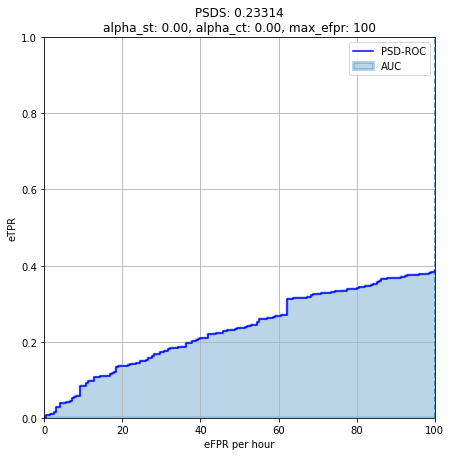

In [6]:
# PSDS evaluation

# Saving PSDS Eval to csv files (comment out if already computed)
for i in detection_thresholds:
    df_psds = pd.DataFrame(dict_PSDS[i])
    df_psds.to_csv(eval_save_dir_PSDS + '{}.tsv'.format(str(i)), index=False, header=True)

# Creating and loading the metadata list as a dataframe (For PSDS)

metadata = {'filename': meta_filename, 'duration': meta_dur}
metadata = pd.DataFrame(metadata)
#metadata.to_csv(eval_save_dir_PSDS + 'metadata.tsv', index=False, header=True)


#metadata = pd.read_csv(eval_save_dir_PSDS + 'metadata.tsv', sep=',')
# Loading the ground truth
groundtruth = pd.read_csv('/Volumes/Expansion/DESEDpublic_eval(1)/dataset/metadata/eval/public.tsv', sep='\t')



# Set PSDS parameters
psds_eval_log = PSDSEval(dtc_threshold=0.1, gtc_threshold=0.1,
                         cttc_threshold=0.3, duration_unit="hour",
                         ground_truth=groundtruth, metadata=metadata)

for i, tsv in enumerate(glob.glob(os.path.join(eval_save_dir_PSDS + '*.tsv'))):
    print(f"Adding Operating Point {i+1:02d}/50", end="\r")
    threshold = float(os.path.splitext(os.path.basename(tsv))[0])
    det = pd.read_csv(tsv)
    info = {"name": f"Op {i+1:02d}", "threshold": threshold}
    psds_eval_log.add_operating_point(det, info=info)
    
psds = psds_eval_log.psds(alpha_ct=0., alpha_st=0., max_efpr=100)
print("PSD-Score:", psds.value)

# plot the PSD-ROC and corresponding PSD-Score
plot_psd_roc(psds)

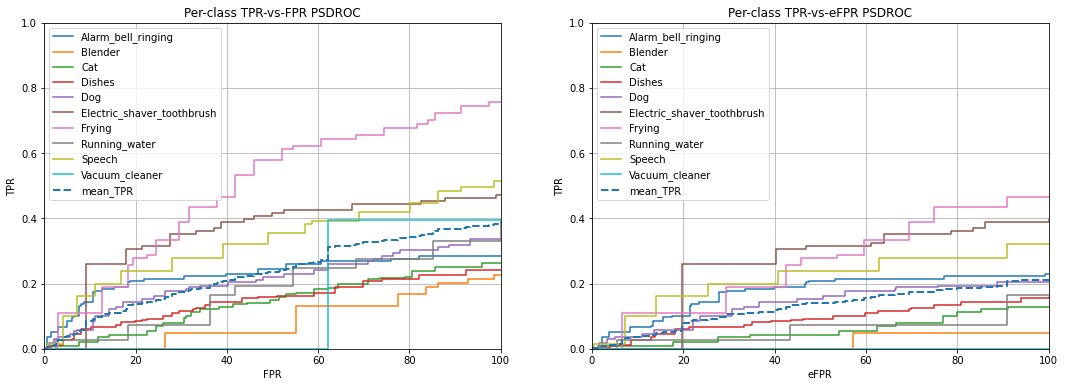

In [7]:
from psds_eval import plot_per_class_psd_roc

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

tpr_vs_fpr, _, _ = psds_eval_log.psd_roc_curves(alpha_ct=0.)
plot_per_class_psd_roc(tpr_vs_fpr, psds_eval_log.class_names, axes=axes[0], title="Per-class TPR-vs-FPR PSDROC", xlabel="FPR", xlim=100)

_, _, tpr_vs_efpr = psds_eval_log.psd_roc_curves(alpha_ct=1.)
plot_per_class_psd_roc(tpr_vs_efpr, psds_eval_log.class_names, axes=axes[1], title="Per-class TPR-vs-eFPR PSDROC", xlabel="eFPR", xlim=100)

In [8]:
det = pd.read_csv(eval_save_dir_PSDS + '0.52.tsv')
macro_f, class_f = psds_eval_log.compute_macro_f_score(det)
print(f"macro F-score: {macro_f*100:.2f}")
for clsname, f in class_f.items():
    print(f"  {clsname}: {f*100:.2f}")

macro F-score: 29.32
  Alarm_bell_ringing: 27.67
  Blender: 13.54
  Cat: 25.05
  Dishes: 16.67
  Dog: 31.98
  Electric_shaver_toothbrush: 36.29
  Frying: 34.96
  Running_water: 19.51
  Speech: 65.20
  Vacuum_cleaner: 22.32


In [9]:
# Recover the operating points for each class based on f-score
class_constraints = list()
for cls in psds_eval_log.class_names[:-1]:
# find the op. point with maximum f1-score, value field is ignored for
# F1-score criteria
    class_constraints.append({"class_name": cls,
                             "constraint": "fscore",
                             "value": None})
class_constraints_table = pd.DataFrame(class_constraints)
selected_ops = psds_eval_log.select_operating_points_per_class(
    class_constraints_table, alpha_ct=0., beta=1.)

for k in range(len(class_constraints)):
    print(model_name)
    print(f"For class {class_constraints_table.class_name[k]}, the highest "
          f"F1-score is achieved at:")
    print(f"\tProbability Threshold: {selected_ops.threshold[k]}, "
          f"TPR: {selected_ops.TPR[k]:.2f}, "
          f"FPR: {selected_ops.FPR[k]:.2f}, "
          f"eFPR: {selected_ops.eFPR[k]:.2f}, "
      f"F1-score: {selected_ops.Fscore[k]:.2f}")

Conv2D_FullData_vREAL_40eps
For class Alarm_bell_ringing, the highest F1-score is achieved at:
	Probability Threshold: 0.1, TPR: 0.37, FPR: 24.48, eFPR: 24.48, F1-score: 0.46
Conv2D_FullData_vREAL_40eps
For class Blender, the highest F1-score is achieved at:
	Probability Threshold: 0.17, TPR: 0.55, FPR: 290.72, eFPR: 290.72, F1-score: 0.13
Conv2D_FullData_vREAL_40eps
For class Cat, the highest F1-score is achieved at:
	Probability Threshold: 0.17, TPR: 0.45, FPR: 95.38, eFPR: 95.38, F1-score: 0.41
Conv2D_FullData_vREAL_40eps
For class Dishes, the highest F1-score is achieved at:
	Probability Threshold: 0.1, TPR: 0.18, FPR: 89.77, eFPR: 89.77, F1-score: 0.23
Conv2D_FullData_vREAL_40eps
For class Dog, the highest F1-score is achieved at:
	Probability Threshold: 0.1, TPR: 0.35, FPR: 124.45, eFPR: 124.45, F1-score: 0.37
Conv2D_FullData_vREAL_40eps
For class Electric_shaver_toothbrush, the highest F1-score is achieved at:
	Probability Threshold: 0.99, TPR: 0.56, FPR: 42.33, eFPR: 42.33, F1-

In [11]:
# Plot event roll

# Code from PSDS toolbox tutorial
# https://github.com/DCASE-REPO/psds_eval/blob/master/jupyter/psds.ipynb
'''

    A Framework for the Robust Evaluation of Sound Event Detection
    C. Bilen, G. Ferroni, F. Tuveri, J. Azcarreta, S. Krstulovic
    In IEEE International Conference on Acoustics, Speech, and Signal Processing (ICASSP). May 2020
    https://arxiv.org/abs/1910.08440
'''

def sedogram(det, gt, label_names, ax=None, title=""):
    """plot the sedogram for the given pair of detections and ground truths"""

    classes = label_names
    n_classes = len(classes)
    
    def _draw_rectangles(df, y_offset, **kwargs):
        n_classes = len(classes)
        for c, grp in df.groupby("event_label"):
            idx = classes.index(c)
            for _, event in grp.iterrows():
                ts = event.onset
                te = event.offset
                dur = te - ts
                ax.add_patch(Rectangle(xy=(ts, n_classes-idx-1+y_offset), width=dur, height=kwargs.get("height"),
                                           facecolor=kwargs.get("facecolor"), alpha=kwargs.get("alpha")))
                
    if ax is None:
        fig, ax = plt.subplots(1, sharex=True, figsize=(14, 4))
    max_x = np.maximum(det.offset.max(), gt.offset.max())
    
    _draw_rectangles(gt, y_offset=0.1, facecolor="b", height=0.8, alpha=1.0)
    _draw_rectangles(det, y_offset=0.35, facecolor="r", height=0.3, alpha=0.7)
    ax.set_ylim([0, n_classes])
    if not np.isnan(max_x):
        ax.set_xlim([0, max_x])
        ax.set_xticks(np.arange(0, max_x, 0.5))
    ax.set_yticks(np.arange(n_classes, 0, -1) - 0.5)
    ax.set_yticklabels(classes)
    ax.set_xlabel("time (s)")
    ax.set_title(title)
    red_patch = Patch(color="red", alpha=0.7, label="System detection")
    blue_patch = Patch(color="blue", label="Ground truth")
    ax.legend(handles=[red_patch, blue_patch])


lcGGi9YQzEQ_45_55.wav
QwczfjpP1BU_0_10.wav
SiX7mSLUl7c_5_15.wav
JT34KB_DYk8_86_96.wav
AYcRe4sIABM_328_338.wav
YYqaGwN2epw_22_32.wav
PddX9valVHE_15_25.wav
_Nn6I3eEt9g_17_27.wav
uu3PCZlcQkE_146_156.wav
Nj30UED-ShI_16_26.wav
qfiOLoU2WZg_400_410.wav
ixFiH87Xtow_433_443.wav
F2y6HsWY21c_43_53.wav
d5Fw3v5gNtA_17_27.wav
FXutBrd9vrM_0_10.wav
iStSYb2NjhE_844_854.wav
f4_7OgNkl-4_25_35.wav
Pxlh9XrZsok_0_10.wav
CN0gaknlKNE_443_453.wav
6nh51gqR47k_1970_1980.wav


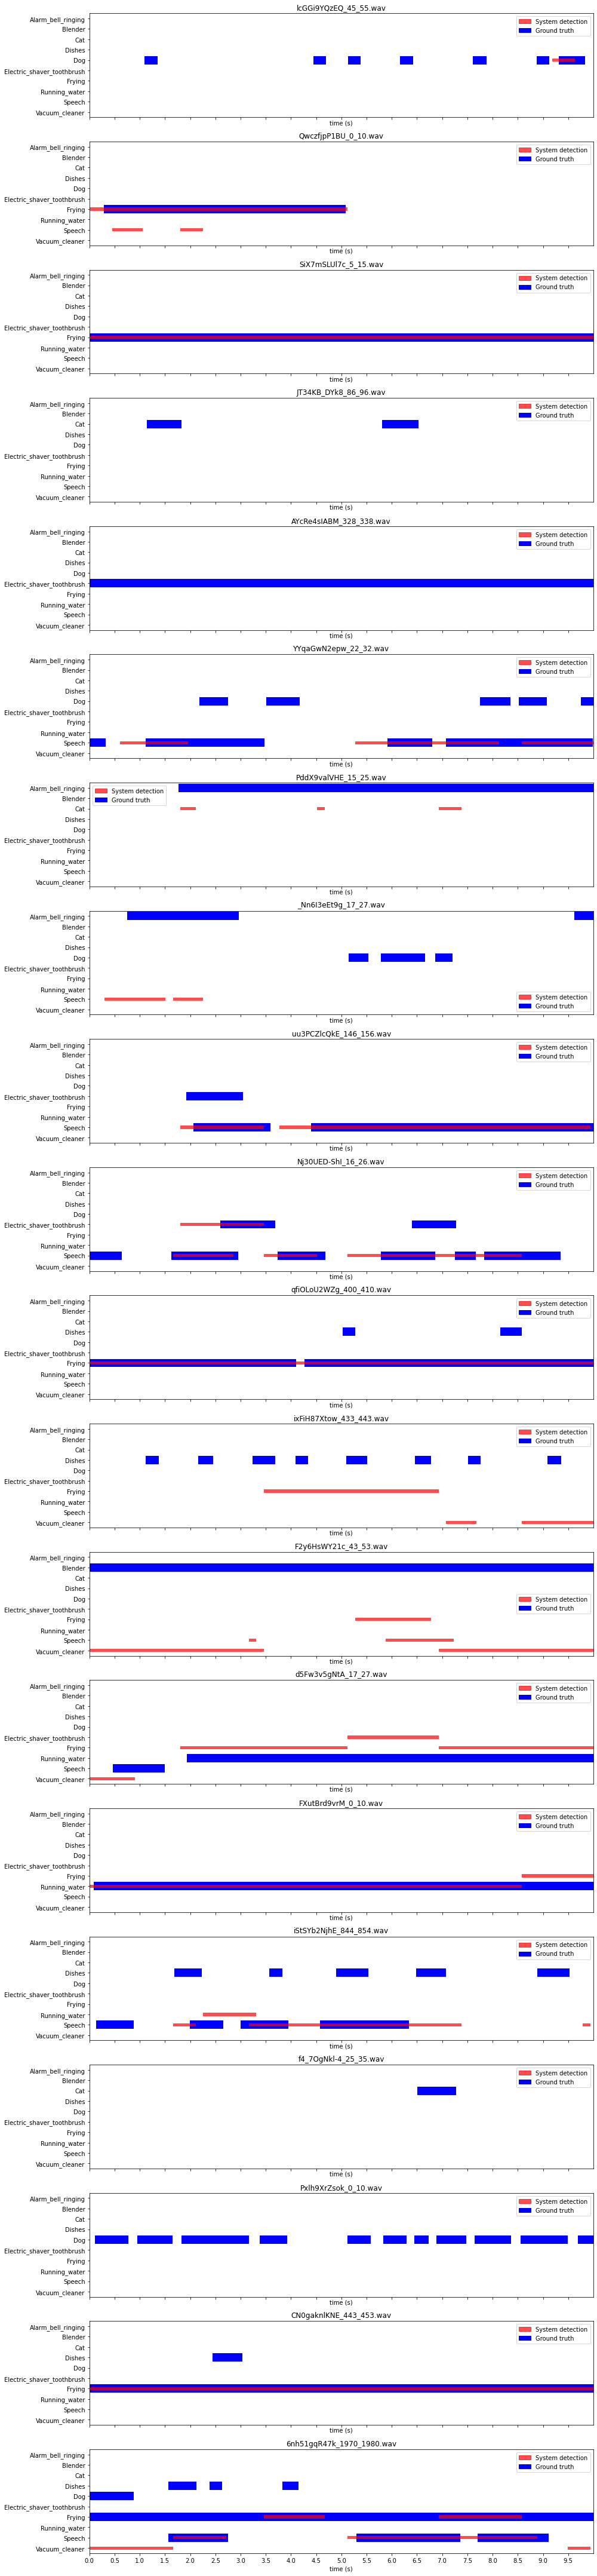

In [12]:
fig, ax = plt.subplots(20, sharex=True, figsize=(14, 60))
count = 0
for i in range(20):
    det = pd.read_csv(eval_save_dir + '{}pred.txt'.format(count), names=["filename", "onset", "offset", "event_label"])
    gt = pd.read_csv(eval_save_dir + '{}truth.txt'.format(count), names=["filename", "onset", "offset", "event_label"])
    sedogram(det, gt, label_names, ax=ax[i], title=gt['filename'][0])
    count += 1
    print(gt["filename"][0])
plt.tight_layout()
plt.savefig(eval_save_dir + '{} sedogram.png'.format(model_name), dpi='figure', facecolor='white')

In [13]:
# In case you just want to check one file
path_to_eval_set = '/Volumes/Expansion/DESEDpublic_eval(1)/dataset/audio/eval/public/'

In [14]:
# Rerun the defs above
sr=24000
win_length=4096
timesteps=64
label_names = ['Alarm_bell_ringing', 'Blender', 'Cat', 'Dishes', 'Dog', 'Electric_shaver_toothbrush', 'Frying', 'Running_water', 'Speech', 'Vacuum_cleaner']

def reshape_pred(y_pred, n_classes):
    y_pred = np.reshape(y_pred, (-1, n_classes))
    return y_pred

def seconds_to_win_of_frames(seconds, win_length, n_frames, sr=sr):
    frame_size_in_samples = win_length / n_frames
    win_of_frames =  int(seconds * sr / frame_size_in_samples)
    return win_of_frames
    
def return_mean_of_win_of_frames(y_pred, win_of_frames):
    # apply before threshold function
    new_size = int(y_pred.shape[0] / win_of_frames)
    y_pred_mean = np.zeros((new_size, y_pred.shape[1]))
    
    for i in range(0, new_size):
        y_pred_mean[i, :] = np.mean(y_pred[int(i * win_of_frames):int(i * win_of_frames + win_of_frames - 1), ], axis=0)
        
    return y_pred_mean

def return_max_of_win_of_frames(y_pred,win_of_frames):
    # apply before threshold function
    new_size = int(y_pred.shape[0] / win_of_frames)
    y_pred_max = np.zeros((new_size, y_pred.shape[1]))
    
    for i in range(0, new_size):
        y_pred_max[i, :] = np.max(y_pred[int(i * win_of_frames):int(i * win_of_frames + win_of_frames - 1), ], axis=0)
        
    return y_pred_max

def return_median_of_win_of_frames(y_pred,win_of_frames):
    # apply before threshold function
    new_size = int(y_pred.shape[0] / win_of_frames)
    y_pred_max = np.zeros((new_size, y_pred.shape[1]))
    
    for i in range(0, new_size):
        y_pred_max[i, :] = np.median(y_pred[int(i * win_of_frames):int(i * win_of_frames + win_of_frames - 1), ], axis=0)
        
    return y_pred_max

def convert_to_time(index, y_pred, audio, sr=sr, win_length=win_length):
    ms_step = (audio.size / y_pred.shape[0]) / sr
    return index * ms_step

def create_txt_from_predictions(y_pred, filename, audio, label_names, threshold=0.5, dict=dict):

    onset = False
    offset = True
    
    threshold = threshold
    for label in range(len(label_names)): # iterate over all classes
        for idx, frame in enumerate(y_pred): # iterate over all frames
            # The frame is an array of 10 values
            # Look up one class at the time
            if frame[label] >= threshold:
                if onset is True:
                    if idx == y_pred.shape[0]-1:
                        dict['offset'].append(10) 
                        offset = True
                        onset = False

                    else:
                        pass
                
                else:
                    onset = True
                    offset = False
                    dict['onset'].append(convert_to_time(idx, y_pred, audio)) 
                    dict['label'].append(label_names[label])
                    dict['filename'].append(filename)
                    if idx == y_pred.shape[0]-1:
                        dict['offset'].append(10) 
                        offset = True
                        onset = False
                    
            else:
                if offset is True:
                    pass
                else:
                    onset = False
                    offset = True
                    dict['offset'].append(convert_to_time(idx, y_pred, audio)) 
                


files = os.listdir(path_to_eval_set)

filenames = [x for x in files if not x.startswith('._')]

def audio_shaper(audio, sr=sr, win_length=win_length):
    if audio.size < 240000:
        audio = np.pad(audio, (0,240000-audio.size))
    elif audio.size > 240000:
        audio = audio[0:240000]
    else:
        audio = audio
    audio = np.pad(audio, (0,5760))
    audio = np.reshape(audio, (6,10,win_length,1))
    
    return audio


56


'   \ndf = pd.DataFrame(dict)\nprint(df)\nx, _ = librosa.load(path_to_file, sr=sr)\nipd.Audio(x, rate=sr)'

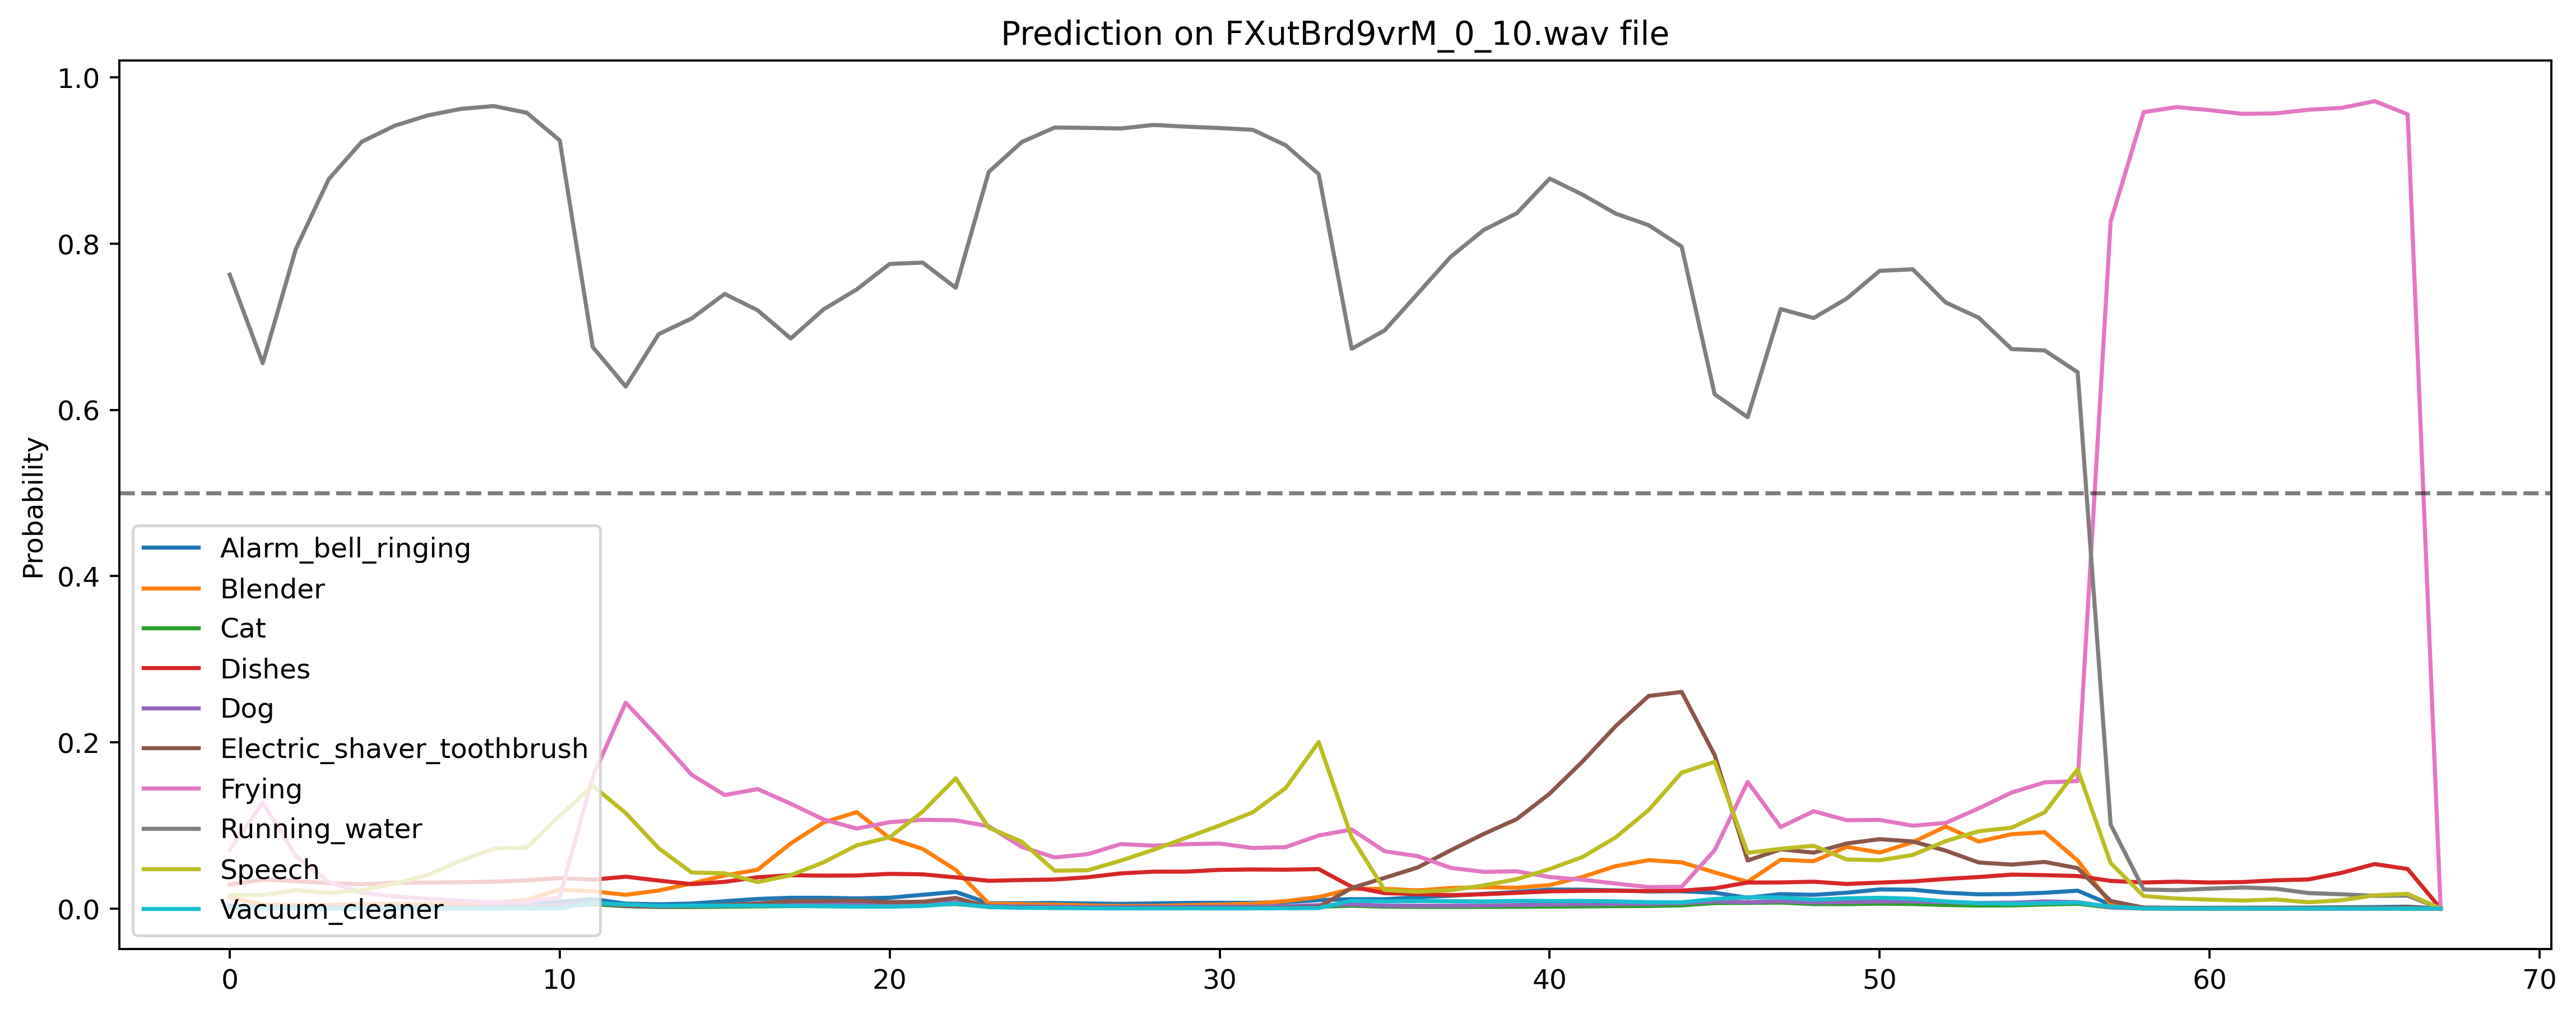

In [15]:
import IPython.display as ipd

def plot_y_pred_y_true(y_pred, label_names, filename):
    plt.figure(figsize= (16,6), dpi=350)
    for i in range(10):
        plt.plot(y_pred[:,i])
        
    
    plt.legend(label_names, loc='lower left')
    
    plt.axhline(0.5, c = 'black', alpha = 0.5, linestyle = '--')
    plt.ylabel('Probability')
    plt.title('Prediction on {} file'.format(filename), loc='center')
    plt.savefig(eval_save_dir + '{} Predictions_mean.png'.format(model_name), dpi='figure', facecolor='white')


dict = 0 # initialize dict
dict = {'filename': [], 'onset': [], 'offset': [], 'label': []}    

#file_to_pred = 'AYcRe4sIABM_328_338.wav'
file_to_pred = 'FXutBrd9vrM_0_10.wav'
#file_to_pred = 'CN0gaknlKNE_443_453.wav'
#file_to_pred = 'Pxlh9XrZsok_0_10.wav'
#file_to_pred = 'uu3PCZlcQkE_146_156.wav'
path_to_file = path_to_eval_set + file_to_pred
time_resolution = 0.15
thres = 0.5
win_of_frames = seconds_to_win_of_frames(time_resolution, win_length, timesteps, sr=sr)
print(win_of_frames)
#mean = False
median = False
audio, _ = librosa.load(path_to_file, sr=sr)
audio = audio_shaper(audio)
y_pred = model.predict(audio)
y_pred = reshape_pred(y_pred, 10)
mean = True
if median is False: 
    if mean is True:        
        y_pred = return_mean_of_win_of_frames(y_pred, win_of_frames)
    else:
        y_pred = return_max_of_win_of_frames(y_pred, win_of_frames)
else:
    y_pred = return_median_of_win_of_frames(y_pred, win_of_frames)
#y_pred = return_max_of_win_of_frames(y_pred, win_of_frames//2)
#y_pred = return_mean_of_win_of_frames(y_pred, 2)
plot_y_pred_y_true(y_pred, label_names, file_to_pred)
#create_txt_from_predictions(y_pred, file_to_pred, audio, label_names, threshold=thres, dict=dict)
'''   
df = pd.DataFrame(dict)
print(df)
x, _ = librosa.load(path_to_file, sr=sr)
ipd.Audio(x, rate=sr)'''

In [ ]:
path = 'f4_7OgNkl-4_25_35.wav'
path_to_file = path_to_eval_set + path
import IPython.display as ipd
x, _ = librosa.load(path_to_file, sr=sr)
ipd.Audio(x, rate=sr)